In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf    
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.animation import FuncAnimation
from matplotlib import cm
import seaborn

In [2]:
# Класс энкапсулирующий логику инициализации выполнения и обучения графа уравнения теплопроводности
class HeatEquation():
    def __init__(self, nxy, tmax, nt, k, f, u0, u0yt, u1yt, ux0t, ux1t):
        self._nxy = nxy # точек в направлении x, y
        self._tmax = tmax # масимальное время
        self._nt = nt # количество моментов времени
        self._k = k # функция k
        self._f = f # функция f
        self._u0   = u0 # начальное условие
        # краевые условия
        self._u0yt = u0yt 
        self._u1yt = u1yt
        self._ux0t = ux0t
        self._ux1t = ux1t
        # шаги по координатам и по времени
        self._h = h = np.array(1./nxy)
        self._ht = ht = np.array(tmax/nt)
        print("ht/h/h:", ht/h/h)

        self._xs = xs = np.linspace(0., 1.,    nxy + 1)
        self._ys = ys = np.linspace(0., 1.,    nxy + 1)
        self._ts = ts = np.linspace(0., tmax,  nt  + 1) 

        from itertools import product
        # узлы сетки, как векторы в пространстве
        self._vs  = vs  = np.array(list(product(xs, ys)), dtype=np.float64)
        self._vcs = vsc = np.array(list(product(xs[1:-1], ys[1:-1])), dtype=np.float64) # внутренние узлы
        
        # векторые в которых рассчитываются значения k
        vkxs = np.array(list(product((xs+h/2)[:-1], ys)), dtype=np.float64) # k_i+0.5,j
        vkys = np.array(list(product(xs, (ys+h/2)[:-1])), dtype=np.float64) # k_i    ,j+0.5

        # сетки со значениями k
        self._kxs = kxs = k(vkxs).reshape((nxy,nxy+1))
        self._kys = kys = k(vkys).reshape((nxy+1,nxy))

        # диагональный оператор D_A 
        D_A = np.zeros((nxy+1, nxy+1))
        D_A[0:nxy+1,0:nxy+0] += kys
        D_A[0:nxy+1,1:nxy+1] += kys
        D_A[0:nxy+0,0:nxy+1] += kxs
        D_A[1:nxy+1,0:nxy+1] += kxs
        self._D_A = D_A = 1 + ht/h/h*D_A[1:nxy,1:nxy] + ht

        # функция, которую будем искать
        self._U_shape    = (nxy+1, nxy+1, nt+1)
        self._U = np.zeros((nxy+1, nxy+1, nt+1)) # выделяем сразу для всех точек и моментов времени,
                                                 # очень много лишней памяти, но мне не жалко
        self._U[:,:,0] = u0(vs).reshape(self._U_shape[:-1]) # ее значение в нулевой момент времени
    
    # метод, строящий граф
    def build_graph(self, learning_rate):
        def reset_graph():
            if 'sess' in globals() and sess:
                sess.close()
            tf.reset_default_graph()
        
        reset_graph()

        nxy = self._nxy

        # входные параметры
        kxs_    = tf.placeholder_with_default(self._kxs, (nxy,nxy+1))
        kys_    = tf.placeholder_with_default(self._kys, (nxy+1,nxy))
        D_A_    = tf.placeholder_with_default(self._D_A, self._D_A.shape)
        U_prev_ = tf.placeholder(tf.float64, (nxy+1, nxy+1), name="U_t-1")
        f_      = tf.placeholder(tf.float64, (nxy-1, nxy-1), name="f")

        # значение функции в данный момент времени, его и будем искать
        U_ = tf.Variable(U_prev_, trainable=True, name="U_t", dtype=tf.float64)

        # срез тензора
        def s(tensor, frm):
            return tf.slice(tensor, frm, (nxy-1, nxy-1), name="slicing")

        # вычисления действия оператора A+_A- на u
        Ap_Am_U_  = s(U_, (0, 1))*s(self._kxs, (0, 1))
        Ap_Am_U_ += s(U_, (2, 1))*s(self._kxs, (1, 1))
        Ap_Am_U_ += s(U_, (1, 0))*s(self._kys, (1, 0))
        Ap_Am_U_ += s(U_, (1, 2))*s(self._kys, (1, 1))
        Ap_Am_U_ *= self._ht/self._h/self._h

        # остатки
        res = D_A_*s(U_,(1, 1)) - Ap_Am_U_ - s(U_prev_, (1, 1)) - self._ht*f_

        # функция потерь, которая будет оптимизироваться
        loss = tf.reduce_sum(tf.square(res), name="loss_res")

        # краевые условия и их влияния на функцию потерь
        u0yt_ = None
        u1yt_ = None
        ux0t_ = None
        ux1t_ = None
        if self._u0yt:        
            u0yt_ = tf.placeholder(tf.float64, (nxy+1,), name="u0yt")
            loss += tf.reduce_sum(tf.square(tf.slice(U_, (0, 0),   (1, nxy+1))
                    - tf.reshape(u0yt_, (1, nxy+1))), name="loss_u0yt")
        if self._u1yt:
            u1yt_ = tf.placeholder(tf.float64, (nxy+1,), name="u1yt")
            loss += tf.reduce_sum(tf.square(tf.slice(U_, (nxy, 0), (1, nxy+1))
                    - tf.reshape(u1yt_, (1, nxy+1))), name="loss_u1yt")
        if self._ux0t:
            ux0t_ = tf.placeholder(tf.float64, (nxy+1,), name="ux0t")
            loss += tf.reduce_sum(tf.square(tf.slice(U_, (0, 0),   (nxy+1, 1))
                    - tf.reshape(ux0t_, (nxy+1, 1))), name="loss_ux0t")
        if self._ux1t:
            ux1t_ = tf.placeholder(tf.float64, (nxy+1,), name="ux1t")
            loss += tf.reduce_sum(tf.square(tf.slice(U_, (0, nxy), (nxy+1, 1))
                    - tf.reshape(ux1t_, (nxy+1, 1))), name="loss_ux1t")
        # на удивления у операции присвоения значения отдельным элементам в тензоре 
        # на момент написания нет реализованного градиента

        # средняя ошибка в точках
        loss /= (nxy+1)*(nxy+1)

        # шаг оптимизации функционала 
        train_step = tf.train.AdamOptimizer(learning_rate, 0.7, 0.97).minimize(loss)

        # возврат операций в словаре, которые будем запускать
        self.g = dict(
            U_prev = U_prev_,
            f = f_,
            u0yt = u0yt_,
            u1yt = u1yt_,
            ux0t = ux0t_,
            ux1t = ux1t_,
            U = U_,
            res = res,
            loss = loss,
            train_step = train_step
        )
        return self.g

    # метод возвращающий необходимые данные для запуска графа
    def _get_graph_feed(self, t_i):
        g   = self.g
        ts  = self._ts
        xs  = self._xs
        ys  = self._ys
        vcs = self._vcs
        nxy = self._nxy
        t   = self._ts[t_i]

        d = {g["U_prev"]: self._U[:,:,t_i-1],
             g["f"]:      self._f(vcs, t).reshape((nxy-1, nxy-1))}

        if g["u0yt"] is not None:
            d[g["u0yt"]] = self._u0yt(ts[t_i-1], ys)
        if g["u1yt"] is not None:
            d[g["u1yt"]] = self._u1yt(ts[t_i-1], ys)
        if g["ux0t"] is not None:
            d[g["ux0t"]] = self._ux0t(ts[t_i-1], xs)
        if g["ux1t"] is not None:
            d[g["ux1t"]] = self._ux1t(ts[t_i-1], xs)
        return d

    # основной метод обучения
    # в каждый момент времени итерируем по значениям функции, 
    # пока не превысим maxiter или ошибка не станет меньше eps
    def train_graph(self, eps, maxiter, miniter):
        g = self.g
        losses = []
        # запускам контекст сессии
        with tf.Session() as sess:
            # инициализируем место под данные в графе
            sess.run(tf.global_variables_initializer(), feed_dict=self._get_graph_feed(0))
            for t_i, t in enumerate(self._ts[1:]):
                t_i += 1
                losses_t = []
                losses.append(losses_t)
                d = self._get_graph_feed(t_i)
                p_loss = float("inf")
                for i in range(maxiter):
                    # запускаем граф  и получаем значения u, функции потерь, 
                    _, self._U[:,:,t_i], loss = sess.run([g["train_step"], g["U"], g["loss"]], feed_dict=d)
                    losses_t.append(loss)
                    if i > miniter and abs(p_loss - loss) < eps:
                        p_loss = loss
                        break
                    p_loss = loss
                print('#', end="")
        return self._U, losses
    
    def check_metadata_partitions_graph(self):
        g   = self.g
        d = self._get_graph_feed(1)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer(), feed_dict=d)
            options = tf.RunOptions(output_partition_graphs=True)
            metadata = tf.RunMetadata()
            c_val = sess.run(g["train_step"], feed_dict=d, options=options, run_metadata=metadata)
        print(metadata.partition_graphs)

    def get_U_as_df(self, step=1):
        nxyp  = self._nxy + 1
        nxyp2 = nxyp**2
        Uf = self._U.reshape((nxy+1)**2,-1)[:, ::step]
        data = np.hstack((self._vs, Uf))
        df = pd.DataFrame(data, columns=["x","y"] + list(range(len(self._ts))[0::step]))
        return df

In [3]:
def wave(v, t, k, c):
    arg = np.dot(v, k.T) - c*t
    arg = np.squeeze(arg)
    return 0.5*(1.+np.sin(arg))

In [4]:
tmax = 0.5
nxy  = 100
nt   = 10000

A = np.array([0.2, 0.15])
B = np.array([0.8, 0.15])
C = np.array([0.5, 0.3])

A1 = np.array([0.8, 0.8])
B1 = np.array([0.6, 0.5])
C1 = np.array([0.5, 0.6])

A2 = np.array([0.2, 0.5])
B2 = np.array([0.7, 0.2])
C2 = np.array([0.5, 0.8])

k1 = 1.0
k2 = 50.0
t1 = 0.0
t2 = 1.0
h0 = 0.0
h1 = 1.0

kn = np.array([[1., 2.]]) * 2
c = 30
omega = 20

def triang(v, k1, k2, A, B, C):
    v_ = v.copy()
    k = k1*np.ones([v.shape[0]])
    v_ = v - A
    B_ = B - A
    C_ = C - A
    m = (v_[:, 0]*B_[1] - v_[:, 1]*B_[0]) / (C_[0]*B_[1] - C_[1]*B_[0])
    l = (v_[:, 0] - m*C_[0]) / B_[0]
    inside = (m > 0.) * (l > 0.) * (m + l < 1.0)
    k[inside] = k2
    return k

def f(v, t):
    return 0.*triang(v, h0, h1, A2, B2, C2)

def u0(v):
    return 0.*triang(v, t1, t2, A2, B2, C2)

foo = np.zeros((nxy+1, 2))

def u0ytb(t, ys):
    return 1 - np.exp(-omega*np.ones(ys.shape[0])*t)

def ux0tb(t, xs):
    return 1 - np.exp(-omega*np.ones(xs.shape[0])*t)

def u1ytb(t, ys):
    return 0. * np.exp(-omega*np.ones(ys.shape[0])*t)

def ux1tb(t, xs):
    return 0. * np.exp(-omega*np.ones(xs.shape[0])*t)


def u0ytz(t, ys):
    return np.zeros(ys.shape[0])

def ux0tz(t, xs):
    return np.zeros(xs.shape[0])

def u1ytz(t, ys):
    return np.zeros(ys.shape[0])

def ux1tz(t, xs):
    return np.zeros(xs.shape[0])


def u0yt(t, ys):
    foo[:, 0] = -1.
    foo[:, 1] = ys
    return wave(foo, t, kn, c) * (1. - np.exp(-omega*t))

def u1yt(t, ys):
    foo[:, 0] = 1.
    foo[:, 1] = ys
    return wave(foo, t, kn, c) * (1. - np.exp(-omega*t))

def ux0t(t, xs):
    foo[:, 1] = -1.
    foo[:, 0] = xs
    return wave(foo, t, kn, c) * (1. - np.exp(-omega*t))

def ux1t(t, xs):
    foo[:, 1] = 1.
    foo[:, 0] = xs
    return wave(foo, t, kn, c) * (1. - np.exp(-omega*t))

In [5]:
eq = HeatEquation(nxy, tmax, nt, lambda x: triang(x, k1, k2, A2, B2, C2), f, u0, u0ytb, u1ytb, ux0tb, ux1tb)
_ = eq.build_graph(0.001)

ht/h/h: 0.5


In [6]:
# eq.check_metadata_partitions_graph()

In [7]:
%%time
U, losses = eq.train_graph(1e-6, 100, 1)

########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

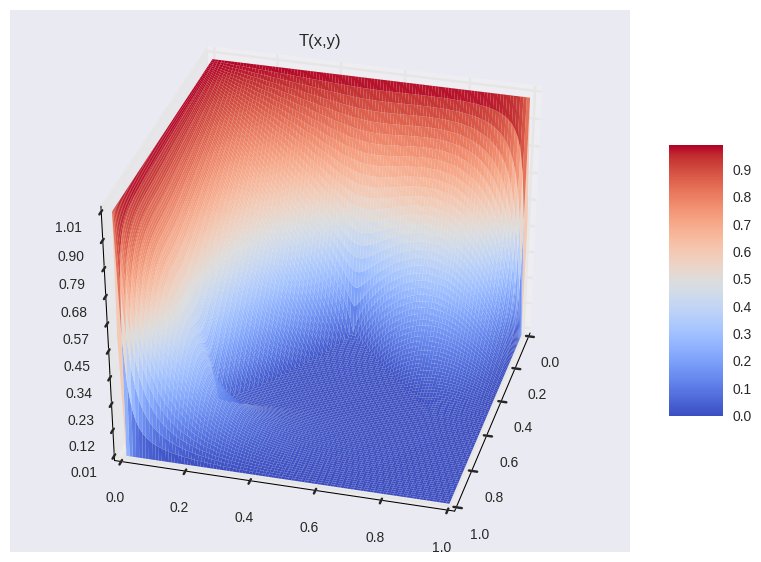

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.interpolate import griddata

data = eq.get_U_as_df(1)
# re-create the 2D-arrays
x1 = np.linspace(data['x'].min(), data['x'].max(), len(data['x'].unique()))
y1 = np.linspace(data['y'].min(), data['y'].max(), len(data['y'].unique()))
x2, y2 = np.meshgrid(x1, y1)
tts = range(0, len(eq._ts), 5)
z2 = griddata((data['x'], data['y']), data[5000], (x2, y2), method='cubic')

fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
ax.view_init(35, 15)
surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0., antialiased=True)
ax.set_zlim(0.01, 1.01)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('T(x,y)')

plt.show()

In [15]:
def make_gif(Udf, fname):
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.ticker import LinearLocator, FormatStrFormatter
    from scipy.interpolate import griddata
    
    fig = plt.figure(figsize=(10,7))

    ts = list(Udf.columns[2:])
    data = Udf

    # преобразуем сетку в данные, которые умеет рисовать matplotlib
    x1 = np.linspace(data['x'].min(), data['x'].max(), len(data['x'].unique()))
    y1 = np.linspace(data['y'].min(), data['y'].max(), len(data['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2s = list(map(lambda x: griddata((data['x'], data['y']), data[x], (x2, y2), method='cubic'), ts))

    zmax = np.max(np.max(data.iloc[:, 2:])) + 0.01
    zmin = np.min(np.min(data.iloc[:, 2:])) - 0.01

    plt.grid(True)
    ax = fig.gca(projection='3d')
    ax.view_init(35, 15)
    ax.set_zlim(zmin, zmax)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    norm = matplotlib.colors.Normalize(vmin=zmin, vmax=zmax, clip=False)
    surf = ax.plot_surface(x2, y2, z2s[0], rstride=1, cstride=1, norm=norm, cmap=cm.coolwarm, linewidth=0., antialiased=True)
    fig.colorbar(surf, shrink=0.5, aspect=5)

    # функция перерисовки картинки в новом кадре
    def update(t_i):
        label = 'timestep {0}'.format(t_i)
        ax.clear()
        print(label)
        surf = ax.plot_surface(x2, y2, z2s[t_i], rstride=1, cstride=1, norm=norm, cmap=cm.coolwarm, linewidth=0., antialiased=True)
        ax.view_init(35, 15+0.5*t_i)
        ax.set_zlim(zmin, zmax)
        return surf,
    # создание и сохранение анимации
    anim = FuncAnimation(fig, update, frames=range(len(z2s)), interval=50)
    anim.save(fname, dpi=80, writer='imagemagick')


In [16]:
def make_2d_gif(U, fname, step=1):
    fig = plt.figure(figsize=(10,7))

    zmax = np.max(np.max(U)) + 0.01
    zmin = np.min(np.min(U)) - 0.01
    norm = matplotlib.colors.Normalize(vmin=zmin, vmax=zmax, clip=False)
    im=plt.imshow(U[:,:,0], interpolation='bilinear', cmap=cm.coolwarm, norm=norm)
    plt.grid(False)
    nst = U.shape[2] // step

    # функция перерисовки картинки в новом кадре
    def update(i):
        im.set_array(U[:,:,i*step])
        return im
    # создание и сохранение анимации
    anim = FuncAnimation(fig, update, frames=range(nst), interval=50)
    anim.save(fname, dpi=80, writer='imagemagick')

In [17]:
make_2d_gif(U[:,:,:], "test0_2d.gif", 100)

In [18]:
make_gif(eq.get_U_as_df(100), "test0.gif")

timestep 0
timestep 0
timestep 1
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
timestep 9
timestep 10
timestep 11
timestep 12
timestep 13
timestep 14
timestep 15
timestep 16
timestep 17
timestep 18
timestep 19
timestep 20
timestep 21
timestep 22
timestep 23
timestep 24
timestep 25
timestep 26
timestep 27
timestep 28
timestep 29
timestep 30
timestep 31
timestep 32
timestep 33
timestep 34
timestep 35
timestep 36
timestep 37
timestep 38
timestep 39
timestep 40
timestep 41
timestep 42
timestep 43
timestep 44
timestep 45
timestep 46
timestep 47
timestep 48
timestep 49
timestep 50
timestep 51
timestep 52
timestep 53
timestep 54
timestep 55
timestep 56
timestep 57
timestep 58
timestep 59
timestep 60
timestep 61
timestep 62
timestep 63
timestep 64
timestep 65
timestep 66
timestep 67
timestep 68
timestep 69
timestep 70
timestep 71
timestep 72
timestep 73
timestep 74
timestep 75
timestep 76
timestep 77
timestep 78
timestep 79
timestep 80
timestep 81
timestep 82
tim